In [123]:
from collections import defaultdict

import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE
import xgboost as xgb

In [124]:
WINDOW = 16  # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
INTERVAL = '2y'  # use "period" instead of start/end
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# (optional, default is '1mo')
symbol = 'AAPL'  # Symbol of the desired stock

# one day 16 rows of data


In [125]:
data = yf.download(  # or pdr.get_data_yahoo(...
    tickers=symbol,

    period=INTERVAL,

    interval=FETCH_INTERVAL,

    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by='ticker',

    # adjust all OHLC automatically
    # (optional, default is False)
    # auto_adjust = True,

    # download pre/post regular market hours data
    # (optional, default is False)
    prepost=True,

    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads=False,

    # proxy URL scheme use use when downloading?
    # (optional, default is None)
    proxy=None
)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2019-09-04 04:00:00-04:00,52.2250,52.295000,52.197500,52.255000,52.255000,0
2019-09-04 05:00:00-04:00,52.2450,52.275000,52.142500,52.185000,52.185000,0
2019-09-04 06:00:00-04:00,52.1825,52.182500,52.057500,52.057500,52.057500,0
2019-09-04 07:00:00-04:00,52.1175,52.122500,52.005000,52.062500,52.062500,0
2019-09-04 08:00:00-04:00,52.0400,52.175000,52.037500,52.137500,52.137500,0
...,...,...,...,...,...,...
2021-09-03 15:30:00-04:00,154.2500,154.449997,154.160004,154.309998,154.309998,5675878
2021-09-03 16:00:00-04:00,154.3100,154.380000,146.520300,154.235000,154.235000,0
2021-09-03 17:00:00-04:00,154.2200,154.340000,154.220000,154.280000,154.280000,0


In [126]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)
important_columns = ['open', 'high', 'low', 'close', 'volume']

In [127]:

def calculate_diffs(diff_number, col_name):
    new_col_name = f'{col_name}_{diff_number}'
    data[new_col_name] = data[col_name].diff(diff_number)

In [128]:
# for name in important_columns:
#     for i in range(1, 11):
#         calculate_diffs(i, name)
#
# data.head(10)

In [129]:
data = data.dropna()

<AxesSubplot:xlabel='Datetime'>

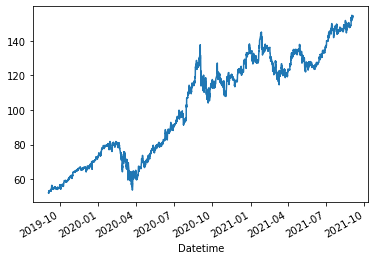

In [130]:
data['close'].plot()

In [131]:
data['close_pct'] = data['close'].pct_change()
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2019-09-04 04:00:00-04:00,52.2250,52.2950,52.1975,52.2550,52.2550,0,NaN
2019-09-04 05:00:00-04:00,52.2450,52.2750,52.1425,52.1850,52.1850,0,-0.001340
2019-09-04 06:00:00-04:00,52.1825,52.1825,52.0575,52.0575,52.0575,0,-0.002443
2019-09-04 07:00:00-04:00,52.1175,52.1225,52.0050,52.0625,52.0625,0,0.000096
2019-09-04 08:00:00-04:00,52.0400,52.1750,52.0375,52.1375,52.1375,0,0.001441


In [132]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,8396.000000,8396.000000,8396.000000,8396.000000,8396.000000,8.396000e+03,8395.000000
mean,102.964636,103.386105,102.443079,102.969560,102.969560,3.847138e+06,0.000146
std,30.003943,30.356120,29.835555,30.000842,30.000842,6.954359e+06,0.005807
min,51.902500,52.029999,50.978220,51.907501,51.907501,0.000000e+00,-0.085960
25%,73.162500,73.437502,72.779373,73.197323,73.197323,0.000000e+00,-0.001620
50%,113.931250,114.401451,113.042500,113.926251,113.926251,0.000000e+00,0.000094
75%,127.820000,128.300000,127.200000,127.805002,127.805002,5.646446e+06,0.001966
max,154.690002,438.440000,154.389999,154.690002,154.690002,9.845401e+07,0.078661


In [133]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    # del (data['Adj Close'])

    return data


In [134]:
data

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2019-09-04 04:00:00-04:00,52.2250,52.295000,52.197500,52.255000,52.255000,0,NaN
2019-09-04 05:00:00-04:00,52.2450,52.275000,52.142500,52.185000,52.185000,0,-0.001340
2019-09-04 06:00:00-04:00,52.1825,52.182500,52.057500,52.057500,52.057500,0,-0.002443
2019-09-04 07:00:00-04:00,52.1175,52.122500,52.005000,52.062500,52.062500,0,0.000096
2019-09-04 08:00:00-04:00,52.0400,52.175000,52.037500,52.137500,52.137500,0,0.001441
...,...,...,...,...,...,...,...
2021-09-03 15:30:00-04:00,154.2500,154.449997,154.160004,154.309998,154.309998,5675878,0.000421
2021-09-03 16:00:00-04:00,154.3100,154.380000,146.520300,154.235000,154.235000,0,-0.000486
2021-09-03 17:00:00-04:00,154.2200,154.340000,154.220000,154.280000,154.280000,0,0.000292


In [135]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct'], dtype='object')

In [136]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [137]:
data = _get_indicator_data(data)
data['close_shift'] = data.shift(-WINDOW)['close']
moved_price = data['close_shift'].copy()
data

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-04 04:00:00-04:00,52.2250,52.295000,52.197500,52.255000,52.255000,0,NaN,0.000000e+00,0,0.000000,...,0.000000,52.255000,0.000000,0.000000,0.000000,0.000000,-49.251993,0.000000,0.000000,52.2000
2019-09-04 05:00:00-04:00,52.2450,52.275000,52.142500,52.185000,52.185000,0,-0.001340,0.000000e+00,0,0.000000,...,0.000000,52.224029,0.000000,0.000000,0.000000,0.000000,-0.133958,-0.134048,-0.133958,52.7575
2019-09-04 06:00:00-04:00,52.1825,52.182500,52.057500,52.057500,52.057500,0,-0.002443,0.000000e+00,0,0.000000,...,0.000000,52.150343,0.000000,0.000000,0.000000,0.000000,-0.244323,-0.244622,-0.377954,52.8975
2019-09-04 07:00:00-04:00,52.1175,52.122500,52.005000,52.062500,52.062500,0,0.000096,0.000000e+00,0,0.000000,...,0.000000,52.111580,0.000000,0.000000,0.000000,0.000000,0.009605,0.009604,-0.368386,53.0000
2019-09-04 08:00:00-04:00,52.0400,52.175000,52.037500,52.137500,52.137500,0,0.001441,0.000000e+00,0,0.000000,...,0.000000,52.123059,0.000000,0.000000,0.000000,0.000000,0.144058,0.143954,-0.224859,52.8400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-03 15:30:00-04:00,154.2500,154.449997,154.160004,154.309998,154.309998,5675878,0.000421,1.789112e+09,611972103,0.249253,...,1.201609,153.906144,0.194791,12.731104,3.727827,9.003277,0.042142,0.042133,195.301880,NaN
2021-09-03 16:00:00-04:00,154.3100,154.380000,146.520300,154.235000,154.235000,0,-0.000486,1.789112e+09,611972103,0.273707,...,0.309501,153.910344,0.191633,3.018885,3.586038,-0.567153,-0.048602,-0.048614,195.158358,NaN
2021-09-03 17:00:00-04:00,154.2200,154.340000,154.220000,154.280000,154.280000,0,0.000292,1.789112e+09,611972103,0.231714,...,-0.042455,153.915894,0.259943,-5.856588,1.697513,-7.554101,0.029176,0.029172,195.244474,NaN


In [138]:
moved_price


Datetime
2019-09-04 04:00:00-04:00    52.2000
2019-09-04 05:00:00-04:00    52.7575
2019-09-04 06:00:00-04:00    52.8975
2019-09-04 07:00:00-04:00    53.0000
2019-09-04 08:00:00-04:00    52.8400
                              ...   
2021-09-03 15:30:00-04:00        NaN
2021-09-03 16:00:00-04:00        NaN
2021-09-03 17:00:00-04:00        NaN
2021-09-03 18:00:00-04:00        NaN
2021-09-03 19:00:00-04:00        NaN
Name: close_shift, Length: 8396, dtype: float64

In [139]:
def create_class(df):
    higher_threshold = 1.5
    lowest_threshold = -1.5
    last_values_higher = []
    last_values_lower = []
    df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
    while True:
        class_counts = df['class_column'].value_counts()
        if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
            break

        if len(last_values_higher) == 3:
            last_values_higher.pop(0)
        if len(last_values_lower) == 3:
            last_values_lower.pop(0)

        last_values_higher.append(higher_threshold)
        last_values_lower.append(lowest_threshold)
        if class_counts[0] > class_counts[1]:
            higher_threshold -= 0.01
        if class_counts[0] > class_counts[-1]:
            lowest_threshold += 0.01
        if class_counts[0] < class_counts[1]:
            higher_threshold += 0.01
        if class_counts[0] < class_counts[-1]:
            lowest_threshold -= 0.01

        if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
            break
        df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)),
                                      axis=1)
    return df


data = create_class(data)

data


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-04 04:00:00-04:00,52.2250,52.295000,52.197500,52.255000,52.255000,0,NaN,0.000000e+00,0,0.000000,...,52.255000,0.000000,0.000000,0.000000,0.000000,-49.251993,0.000000,0.000000,52.2000,0
2019-09-04 05:00:00-04:00,52.2450,52.275000,52.142500,52.185000,52.185000,0,-0.001340,0.000000e+00,0,0.000000,...,52.224029,0.000000,0.000000,0.000000,0.000000,-0.133958,-0.134048,-0.133958,52.7575,0
2019-09-04 06:00:00-04:00,52.1825,52.182500,52.057500,52.057500,52.057500,0,-0.002443,0.000000e+00,0,0.000000,...,52.150343,0.000000,0.000000,0.000000,0.000000,-0.244323,-0.244622,-0.377954,52.8975,1
2019-09-04 07:00:00-04:00,52.1175,52.122500,52.005000,52.062500,52.062500,0,0.000096,0.000000e+00,0,0.000000,...,52.111580,0.000000,0.000000,0.000000,0.000000,0.009605,0.009604,-0.368386,53.0000,1
2019-09-04 08:00:00-04:00,52.0400,52.175000,52.037500,52.137500,52.137500,0,0.001441,0.000000e+00,0,0.000000,...,52.123059,0.000000,0.000000,0.000000,0.000000,0.144058,0.143954,-0.224859,52.8400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-03 15:30:00-04:00,154.2500,154.449997,154.160004,154.309998,154.309998,5675878,0.000421,1.789112e+09,611972103,0.249253,...,153.906144,0.194791,12.731104,3.727827,9.003277,0.042142,0.042133,195.301880,NaN,0
2021-09-03 16:00:00-04:00,154.3100,154.380000,146.520300,154.235000,154.235000,0,-0.000486,1.789112e+09,611972103,0.273707,...,153.910344,0.191633,3.018885,3.586038,-0.567153,-0.048602,-0.048614,195.158358,NaN,0
2021-09-03 17:00:00-04:00,154.2200,154.340000,154.220000,154.280000,154.280000,0,0.000292,1.789112e+09,611972103,0.231714,...,153.915894,0.259943,-5.856588,1.697513,-7.554101,0.029176,0.029172,195.244474,NaN,0


In [140]:
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\{symbol}_{INTERVAL}_{WINDOW}_diff_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

C:\Users\exomat\Desktop\repo\magisterka_analiza\data\results\train_test\AAPL_2y_16_diff_06_09_2021 23_14_24_full.csv


In [141]:

# Class divide
data['class_column'].value_counts()

 0    2828
 1    2787
-1    2781
Name: class_column, dtype: int64

In [142]:
# del (data['close'])
# del (data['close_shift'])
data = data.dropna()

In [143]:
data['class_column'].value_counts()


 0    2811
 1    2787
-1    2781
Name: class_column, dtype: int64

In [144]:
def split_dataframe(df, chunk_size=17):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i * chunk_size:(i + 1) * chunk_size])
    return chunks


def train_model(model, train_x, train_y):
    model.fit(train_x, train_y)

In [145]:
splited_dataframe = split_dataframe(data, 17)
len(splited_dataframe)

493

In [146]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column', 'close_shift']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

In [147]:
classifiers = dict()
# classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=15, random_state=0, criterion='gini',
#                                                                  splitter='best')
# classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=40, random_state=0, criterion='gini',
#                                                                  splitter='best')
# classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
#
#
# classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,
#                                                                  criterion='gini', n_jobs=-1)
#
# classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,
#                                                                  criterion='entropy', n_jobs=-1)
#
# classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0,
#                                                                  criterion='entropy', n_jobs=-1)
#
# classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100, random_state=0,
#                                                                          criterion='friedman_mse', max_depth=3,
#                                                                          learning_rate=0.1)
#
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000, random_state=0,
                                                                         criterion='friedman_mse', max_depth=3,
                                                                         learning_rate=0.5)
#
# classifiers['XGBRFClassifier 1'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=2, n_estimators=1000, eta=0.2 )
# classifiers['XGBRFClassifier 2'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=6, n_estimators=1000, eta=0.3)

# classifiers['XGBClassifier 1'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.2)
# classifiers['XGBClassifier 2'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.3)
#
classifiers_boosted = dict()
# # classifiers_boosted['SGradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
# classifiers_boosted['SXGBClassifier 1'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.2)
# classifiers_boosted['SXGBClassifier 2'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.3)
# classifiers_boosted['SXGBClassifier 3'] = xgb.XGBClassifier(nthread=-1, max_depth=10, n_estimators=1000, eta=0.2)


In [148]:

def calculate_change(predicted, correct, index):
    change_percentage = (((data['close'][index+WINDOW] / data['close'][index])*100)-100)
    if (predicted==1):
        return change_percentage
    if(predicted==0):
        return 0
    if (predicted== -1 ):
        return 0
        # return -change_percentage

<AxesSubplot:xlabel='Datetime'>

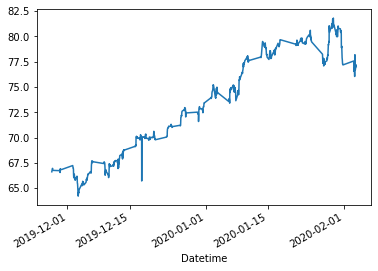

In [149]:
data['close'][1000:1700].plot()


In [ ]:
first_row = 99
start = 100
start_data = splited_dataframe[:first_row + 1]
next_data = splited_dataframe[first_row + 1:first_row + 1 + 31]
print(len(next_data))
score = defaultdict(list)
score_sum = defaultdict(list)
score_ind = defaultdict(list)
score_hour = defaultdict(list)
price_now = defaultdict(list)
price_fut = defaultdict(list)
predicted_classes = defaultdict(list)
correct_classes = defaultdict(list)
points = defaultdict(list)
points_train = defaultdict(list)
score_train = defaultdict(list)
step_headers = []
i = 0
print("start")
temp = []

for idx, day in enumerate(next_data):
    first_row += 1
    start_data.append(day)
    data_set = pd.concat(start_data)
    data_set = create_class(data_set)
    y = data_set['class_column']
    features = [x for x in data_set.columns if x not in ['class_column']]
    x = data_set[features]
    x_train = x.iloc[:-34]
    y_train = y.iloc[:-34]
    x_test = x.iloc[-17:]
    y_test = y.iloc[-17:]

    i = i + 1
    predictions_train = dict()
    predictions = dict()
    print("Calculate: ", first_row)
    for k, v in classifiers.items():
        count = 0
        temp=[]
        for idx in range(0,17):
            temp_x_train = x_train.iloc[idx::17]
            temp_y_train =  y_train.iloc[idx::17]
            temp_x_test = x_test.iloc[idx::17]
            temp_y_test = y_test.iloc[idx::17]
            train_model(v, temp_x_train, temp_y_train)
            el = v.predict(temp_x_test)
            change = calculate_change(el[0], temp_y_test[0], (first_row * 17) + idx)
            if change !=0:
                count +=1
            score_ind[idx].append(change)
            temp.append(change)
            price_now[idx].append(data['close'][(first_row*17)+idx])
            price_fut[idx].append(data['close'][(first_row*17)+idx+WINDOW])
            score_hour[idx].append(change)
            predicted_classes[idx].extend(el)
            correct_classes[idx].append(temp_y_test[0])

        if count!=0:
            score[k].append( sum(temp)/count)
        else:
            score[k].append( sum(temp))

        score_sum[k].append(sum(temp))



31
start
Calculate:  100


In [ ]:
    # rfe = RFE(classifiers['XGBRFClassifier 1'], 10)
    # fited = rfe.fit(x_train, y_train)
    # names = x.columns
    # columns = []
    # for i in range(len(fited.support_)):
    #     if fited.support_[i]:
    #         columns.append(names[i])
    #
    # print("Columns with predictive power:", columns)
    # columns = columns + ['high', 'low', 'volume', 'open']
    # x_test_cropped = x_test[columns]
    # x_train_cropped = x_train[columns]
    # x_test_cropped = x_test_cropped.loc[:, ~x_test_cropped.columns.duplicated()]
    # x_train_cropped = x_train_cropped.loc[:, ~x_train_cropped.columns.duplicated()]
    # for k, v in classifiers_boosted.items():
    #     print("Calculate: ", k)
    #     train_model(v, x_train, y_train)
    #     predicted_class = v.predict(x_test)
    #     for idx, el in enumerate(predicted_class):
    #         score[k].append(calculate_change(el, y_test[idx], (first_row*17)+idx))





In [ ]:
len(score['DecisionTreeClassifier 1'])

In [ ]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
    #     step_headers.append(f'<{a},{b}>')
        step_headers.append(f'<{a}>')
len(step_headers)

In [ ]:
headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(score.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_score_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

In [ ]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
    #     step_headers.append(f'<{a},{b}>')
        step_headers.append(f'<{a}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(score_sum.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score_sum.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_sum_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)


In [ ]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
        step_headers.append(f'<{a}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(score_ind.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score_ind.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_points_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

In [ ]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
        step_headers.append(f'<{a}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(price_now.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(price_now.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_price_now_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

In [ ]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
        step_headers.append(f'<{a}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(price_fut.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(price_fut.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_price_fut_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

In [ ]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
        step_headers.append(f'<{a}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(score_hour.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score_hour.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_score_hour_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

In [ ]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
        step_headers.append(f'<{a}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(predicted_classes.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(predicted_classes.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_predicted_classes_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

In [ ]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
        step_headers.append(f'<{a}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(correct_classes.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(correct_classes.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_correct_classes_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

In [ ]:
cenka = []

', '.join(map(str, data['close'][1700+16:1717+16].tolist()))

In [ ]:
cenka = []
for i in range (0,17*31):
    cenka.append( data['close'][(99*17) +WINDOW +i])

b = ', '.join(map(str, cenka))

In [ ]:
predicted_classes

In [ ]:
temp = []
for av in predicted_classes:
   temp.extend(av)